In [14]:
import numpy as np
from tqdm import tqdm
import gym
import math
import random
import matplotlib.pyplot as plt

In [15]:
env = gym.make('Taxi-v3')
num_actions = env.action_space
num_obs = env.observation_space
R, G, B, Y = env.unwrapped.locs
R, G, B, Y = list(R), list(G), list(B), list(Y)
env.reset()


(141, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [16]:
def get_state(state):
    row, col, pass_id, dest_id = env.unwrapped.decode(state)
    state = np.asarray([row,col,pass_id,dest_id])
    return state

print(get_state(123)[0:2])
print(R,G,B,Y)

[1 1]
[0, 0] [0, 4] [4, 0] [4, 3]


In [17]:
curr_state = get_state(env.s)
print("Taxi at",curr_state[0:2])
next_state, reward, done, _, _ = env.step(4)
row, col, pass_id, dest_id = env.unwrapped.decode(next_state)

Taxi at [1 2]


In [18]:
q_r = np.zeros((500,4))
q_b = np.zeros((500,4))
q_g = np.zeros((500,4))
q_y = np.zeros((500,4))
q = np.zeros((500,10))

In [19]:
# Set the number of episodes and maximum number of steps per episode
EPS = 10000
MAX_STEPS = 500
EXP = 1
# Set the learning rate, discount factor, and exploration rate
ALPHA = 0.15
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

In [20]:
def choose_action(state,qs,eps):
    #print(np.shape(q))
    length = np.shape(qs)[1]
    if not qs[state].any():
        return random.randint(0,length-1)
    action = np.argmax(qs[state])
    
    if np.random.rand() < eps:
        action = np.random.randint(0,length-1)
        return action
    return action   

def choose_action_option(state,qs):
    action = np.argmax(qs[state])
    return action  

In [21]:
# Options where policy is greedy wrt the corresponding q Value function
def Red(q_r,state,eps):
    optdone = False
    optact = choose_action(state,q_r,eps)
    state = get_state(state)
    if state[0] == R[0] and state[1] == R[1]:
        optdone = True
    return optact,optdone

def Green(q_g,state,eps):
    optdone = False
    optact = choose_action(state,q_g,eps)
    state = get_state(state)
    if state[0] == G[0] and state[1] == G[1]:
        optdone = True
    return optact,optdone
    
def Yellow(q_y,state,eps):
    optdone = False
    optact = choose_action(state,q_y,eps)
    state = get_state(state)
    if state[0] == Y[0] and state[1] == Y[1]:
        optdone = True
    return optact,optdone 

def Blue(q_b,state,eps):
    optdone = False
    optact = choose_action(state,q_b,eps)
    state = get_state(state)
    if state[0] == B[0] and state[1] == B[1]:
        optdone = True
    return optact,optdone 

SMDP

In [22]:
class SMDP:
    def __init__(self):
        self.avg_reward = []
        self.total_reward = []

    def Qlearn(self):
        epsilon = 0.1
        for episode in range(5000):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0
            while not done :
                steps += 1
                action = choose_action(state,q,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward+= reward
                    q[state,action] = q[state, action] + ALPHA * (reward + GAMMA * np.max(q[next_state, :])- q[state, action])
                    state = next_state
                reward_bar = 0
                if action > 5 :
                    count = 0
                    optdone = False
                    current_state = state
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(q_r,state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            q_r[state,optact] = q_r[state, optact] + ALPHA * (reward + GAMMA * np.max(q_r[next_state, :])- q_r[state, optact])
                        if action == 7:
                            optact, optdone = Green(q_g,state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            q_g[state,optact] = q_g[state, optact] + ALPHA * (reward + GAMMA * np.max(q_g[next_state, :])- q_g[state, optact])
                        if action == 8:
                            optact, optdone = Blue(q_b,state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            q_b[state,optact] = q_b[state, optact] + ALPHA * (reward + GAMMA * np.max(q_b[next_state, :])- q_b[state, optact])
                        if action == 9:
                            optact, optdone = Yellow(q_y,state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            q_y[state,optact] = q_y[state, optact] + ALPHA * (reward + GAMMA * np.max(q_y[next_state])- q_y[state, optact])
                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        if optdone == True:
                            q[current_state, action] += ALPHA * (reward_bar - q[current_state, action] + (GAMMA**count) * np.max(q[next_state, :]))
                        state = next_state
                if epsilon > 0.01:
                    epsilon = epsilon*np.exp(-0.01)
            running = 0.35 * ep_reward + (1 - 0.35) * running
            self.avg_reward.append(running)
            self.q=q
            self.total_reward.append(ep_reward)
            print(f"Episode {episode + 1}: Total Reward = {ep_reward}")
        return self.avg_reward, self.total_reward
    
    def plot(self):
        plt.plot(self.avg_reward,label="Moving Average")
        plt.grid()
        plt.plot(self.total_reward,label="Total Rewards",alpha=1, color='orange')
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,self.q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break
        
    

Working

Episode 1: Total Reward = -977
Episode 2: Total Reward = -696


Episode 3: Total Reward = -5258
Episode 4: Total Reward = -855
Episode 5: Total Reward = -1304
Episode 6: Total Reward = -4529
Episode 7: Total Reward = -3815
Episode 8: Total Reward = -1365
Episode 9: Total Reward = -4032
Episode 10: Total Reward = -6283
Episode 11: Total Reward = -1079
Episode 12: Total Reward = -4533
Episode 13: Total Reward = -959
Episode 14: Total Reward = -3332
Episode 15: Total Reward = -1510
Episode 16: Total Reward = -1731
Episode 17: Total Reward = -7622
Episode 18: Total Reward = -4248
Episode 19: Total Reward = -1256
Episode 20: Total Reward = -1190
Episode 21: Total Reward = -3986
Episode 22: Total Reward = -468
Episode 23: Total Reward = -895
Episode 24: Total Reward = -1391
Episode 25: Total Reward = -1423
Episode 26: Total Reward = -137
Episode 27: Total Reward = -3039
Episode 28: Total Reward = -3023
Episode 29: Total Reward = -5552
Episode 30: Total Reward = -1872
Episode 31: Total Reward = -765
Episode 32: Total Reward = -1389
Episode 33: Total Rewar

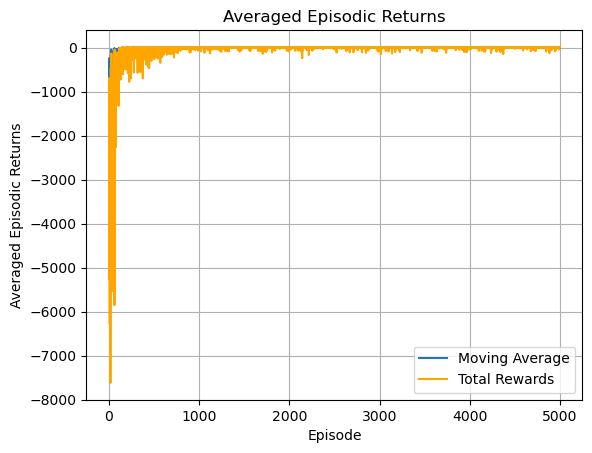

In [23]:
smdp = SMDP()
smdp.Qlearn()
smdp.plot()

INTRA OPTION

In [26]:
q_intra = np.zeros((500,10))

class INTRAOPT:
    def __init__(self):
        self.avg_reward = []
        self.total_reward = []

    def Qlearn(self):
        epsilon = 0.1
        for episode in range(5000):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0
            while not done :
                steps += 1
                action = choose_action(state,q_intra,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward+= reward
                    q_intra[state,action] += ALPHA * (reward + GAMMA * np.max(q_intra[next_state, :])- q_intra[state, action])
                    state = next_state
                
                if action > 5 :
                    count = 0
                    optdone = False
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(q_r,state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            #q_r[state,optact] = q_r[state, optact] + ALPHA * (reward + GAMMA * np.max(q_r[next_state, :])- q_r[state, optact])
                        if action == 7:
                            optact, optdone = Green(q_g,state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            #q_g[state,optact] = q_g[state, optact] + ALPHA * (reward + GAMMA * np.max(q_g[next_state, :])- q_g[state, optact])
                        if action == 8:
                            optact, optdone = Blue(q_b,state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            #q_b[state,optact] = q_b[state, optact] + ALPHA * (reward + GAMMA * np.max(q_b[next_state, :])- q_b[state, optact])
                        if action == 9:
                            optact, optdone = Yellow(q_y,state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            #q_y[state,optact] = q_y[state, optact] + ALPHA * (reward + GAMMA * np.max(q_y[next_state])- q_y[state, optact])
                        
                        ep_reward += reward
                        count += 1
                        q_intra[state,action] += ALPHA * (reward + GAMMA * np.max(q_intra[next_state, :])- q_intra[state, action])
                        state = next_state
                if epsilon > 0.01:
                    epsilon = epsilon*np.exp(-0.01)
            running = 0.35 * ep_reward + (1 - 0.35) * running
            self.avg_reward.append(running)
            self.q=q_intra
            self.total_reward.append(ep_reward)
            print(f"Episode {episode + 1}: Total Reward = {ep_reward}")
        return self.avg_reward, self.total_reward
    
    def plot(self):
        plt.plot(self.avg_reward,label="Moving Average")
        plt.grid()
        plt.plot(self.total_reward,label="Total Rewards",alpha=1, color='orange')
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,self.q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break
        
    

In [27]:
agent2 = INTRAOPT()
agent2.Qlearn()
agent2.plot()

KeyboardInterrupt: 